# Handling data in PyTorch

In this script, we see how to handle data in PyTorch using Datasets and Dataloaders objects.


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import random
import numpy as np
from skimage import transform
import imageio.v2 as io
import soundfile as sf
import fnmatch
from IPython.display import Audio, display
from matplotlib import pyplot as plt
import string

## Image data

First, let's play around with images. We use the data provided in `data/image_corpus`, which is extracted from the [Pokemon dataset](https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types).

### Example


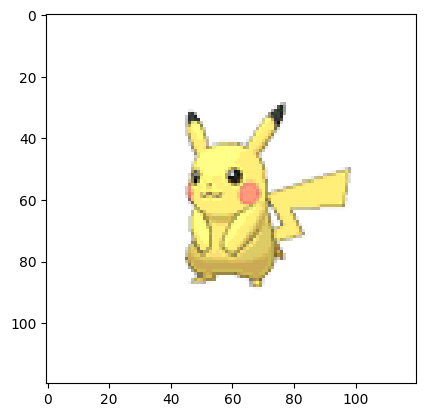

In [2]:
# Load and display one image from the image corpus
image_path = "../data/image_corpus/pikachu.png"
image_example = io.imread(image_path, pilmode="RGBA")
plt.figure()
plt.imshow(image_example)
# plt.xticks([]), plt.yticks([])
plt.show()

In [3]:
# PNG images usually have 4 channels (red, green, blue, and transparency)
print(image_example.shape)

(120, 120, 4)


In [4]:
# You can get the name of the pokemon by removing 'data/image_corpus/' and '.png' from the image_path
name = image_path.replace("../data/image_corpus/", "").replace(".png", "")
print(name)

pikachu


### Dataset

We now create an image Dataset. It's a python class that allows to store and manipulate all the data instead of manually load and process each data sample (=image) independently.

A `Dataset` python class must consists of at least 3 methods:

- `__init__`, which initializes the object when instanciated.
- `__len__`, which returns the lenght (= number of samples) of the dataset.
- `__getitem__`, which allows to access a sample using it's index number.

Of course you can add as many methods as you want for preprocessing the data if needed.

**Note**: Python classes usually define and use some variables/data/tensors/dictionary etc. internally. These are called _attributes_, and should be defined in the `__init__` method with a specific structure (the name should start by `self.`, see below). This allows you to access these attributes in other methods, or after defining your dataset.


In [5]:
class ImageDataset(Dataset):
    def __init__(self, image_dir):
        """Initialize the attributes of the object of the class."""
        self.image_dir = image_dir
        self.image_path_list = sorted(self._find_files(image_dir))

    def __len__(self):
        """Return the size of the dataset."""
        return len(self.image_path_list)

    def __getitem__(self, index):
        """Return a data sample (=image) for a given index, along with the name of the corresponding pokemon."""

        # TO DO:
        # - get the image path corresponding to 'index' (use the list 'self.image_path_list')
        image_path = self.image_path_list[index]

        # - get the pokemon name
        name = image_path.replace(self.image_dir, "").replace(".png", "")

        # - load the image into a numpy array x
        x = io.imread(image_path, pilmode="RGBA")

        # - transform x into a pytorch tensor of type 'float'
        x = torch.from_numpy(x).float()

        # - normalize it so x ranges between 0 and 1
        x = x / 255.0

        # - return the tensor x and the pokemon name
        return x, name

    def _find_files(self, directory, pattern="*.png"):
        """Recursively find all files matching the pattern."""
        image_path_list = []
        for root, dirnames, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                image_path_list.append(os.path.join(root, filename))
        return image_path_list


In [6]:
# We can initialize the dataset by providing the directory of the image corpus data
image_dir = "../data/image_corpus/"
dataset = ImageDataset(image_dir=image_dir)

# You can use the '_find_files' method to get the list of images paths
image_path_list = dataset._find_files(image_dir)

# Equivalently, since this list is stored as an inner attribute, you can access it directly:
image_path_list = dataset.image_path_list

# Display all file paths
for image_file_path in image_path_list:
    print(image_file_path)
print("Number of images in the list", len(image_path_list))

../data/image_corpus/abomasnow.png
../data/image_corpus/aegislash-blade.png
../data/image_corpus/alakazam.png
../data/image_corpus/ambipom.png
../data/image_corpus/arcanine.png
../data/image_corpus/arceus.png
../data/image_corpus/archeops.png
../data/image_corpus/armaldo.png
../data/image_corpus/aromatisse.png
../data/image_corpus/articuno.png
../data/image_corpus/aurorus.png
../data/image_corpus/avalugg.png
../data/image_corpus/barbaracle.png
../data/image_corpus/beedrill.png
../data/image_corpus/blastoise.png
../data/image_corpus/blaziken.png
../data/image_corpus/bouffalant.png
../data/image_corpus/braviary.png
../data/image_corpus/camerupt.png
../data/image_corpus/carracosta.png
../data/image_corpus/chandelure.png
../data/image_corpus/charizard.png
../data/image_corpus/chesnaught.png
../data/image_corpus/clawitzer.png
../data/image_corpus/cobalion.png
../data/image_corpus/cofagrigus.png
../data/image_corpus/conkeldurr.png
../data/image_corpus/crawdaunt.png
../data/image_corpus/crust

In [7]:
# To get the length of the dataset, you can use 'len(dataset)', which calls the method '__len__'
print("Dataset length:", dataset.__len__())
print("Dataset length:", len(dataset))

Dataset length: 151
Dataset length: 151


torch.Size([120, 120, 4]) 
Name: abomasnow


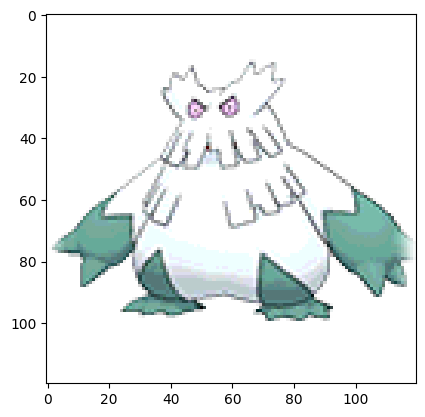

In [8]:
# TO DO: load the image with index '0' from the dataset, print its shape, and plot it with the pokemon name
# hint: you can use 'dataset[0]', which is the same as '__getitem__(index)'

image, image_name = dataset.__getitem__(0)
# image, image_name = dataset[0]

plt.figure()
plt.imshow(image)
print(image.shape, "\nName:", image_name)


### Dataloader

A `Dataset` object stores all the data, and it might be very large. In practice, when using deep neural networks, we want to divide it into small packs (or _minibatches_) of data, in order to feed the network and compute stochatstic gradient descent. To that end, we create a `Dataloader`: it's a python class which samples over the dataset (that's the _batch sampler_) and assembles the data and labels (using a _collate function_) to generate batches.

&nbsp;

<center><a href="https://twitter.com/i/status/1363494433715552259">
    <img src="https://pbs.twimg.com/ext_tw_video_thumb/1363493414361305099/pu/img/x_qwSxBU2l0o5Y2z.jpg" width="500"></a>
(click on the image above to check the animation)
</center>

The good news is that there's a Pytorch function that does it automatically, so we don't need to bother with coding the batch sampler nor the collate function.


In [9]:
# Set the batch size (=number of samples/images in each batch) and create the dataloader
batch_size = 5
image_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

torch.Size([5, 120, 120, 4])


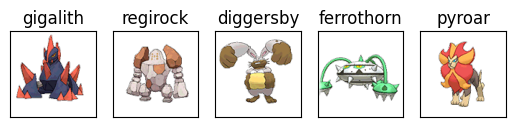

In [10]:
# Take one batch and print the shape of the image tensor
image_batch_data, image_batch_name = next(iter(image_dataloader))
print(image_batch_data.shape)

# Plot the images along with the corresponding names
plt.figure()
for ib in range(batch_size):
    plt.subplot(1, batch_size, ib + 1)
    plt.imshow(image_batch_data[ib, :])
    plt.title(image_batch_name[ib])
    plt.xticks([]), plt.yticks([])
plt.show()

In [11]:
# The total number of batches can be access easily
print("Dataloader length (number of batches):", len(image_dataloader))

Dataloader length (number of batches): 31


In [12]:
# TO DO: iterate over the dataloader (use a for loop) and print the shape of each batch of image.

i = iter(image_dataloader)
for j in range(len(image_dataloader)):
    batch_data, batch_name = next(i)
    print(batch_data.shape)

torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([1, 120, 120, 4])


You should remark from the code above that the last batch has a different size than the others. This is because in the dataset there are 150 images and the `batch_size` is 5: therefore there are 30 batches with 5 images, and the last batch contains the remaining 1 image.

To avoid this (which might be useful in some applications where you need to process each batch with the same size), you can get ridd of the last batch with a different size. To do so, simply use the `drop_last=True` option when defining the dataloader.


In [13]:
# TO DO: Define the dataloader while removing the last batch, and print the length of the new dataloader.
batch_size = 5
image_dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

print("Dataloader length (number of batches):", len(image_dataloader))

Dataloader length (number of batches): 30


torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])


/tmp/ipykernel_20263/3753046133.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])
torch.Size([5, 120, 120, 4])


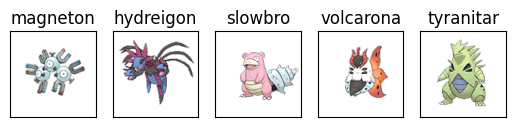

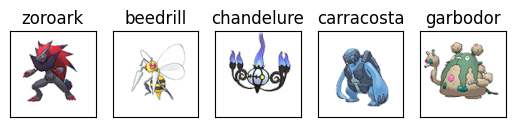

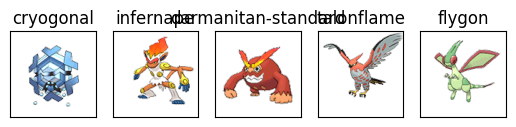

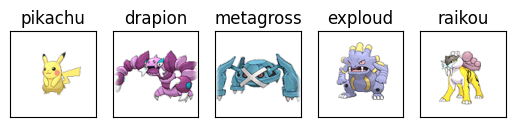

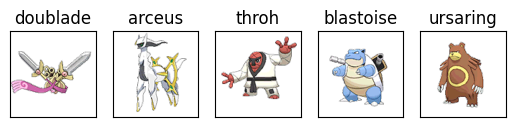

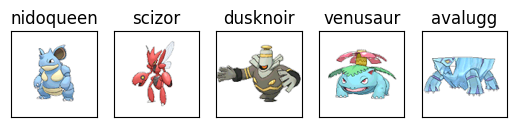

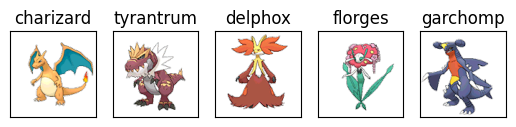

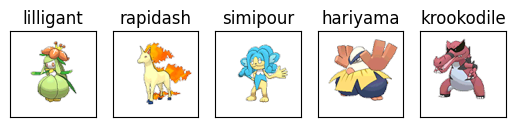

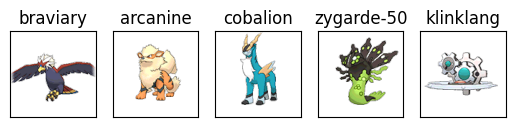

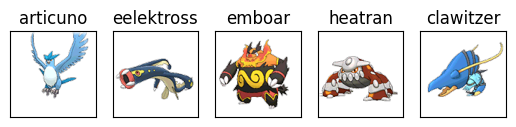

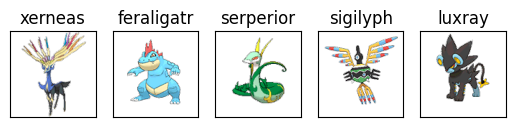

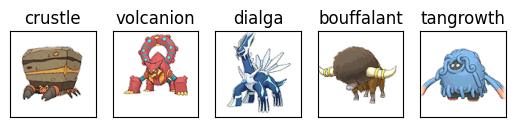

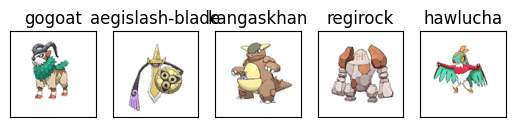

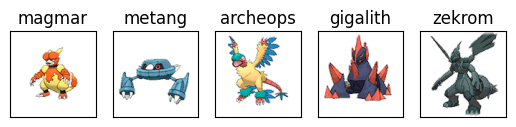

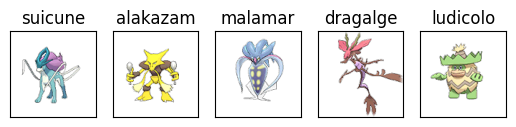

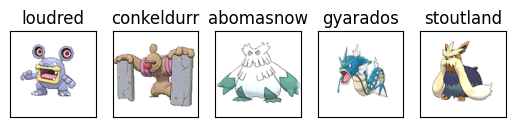

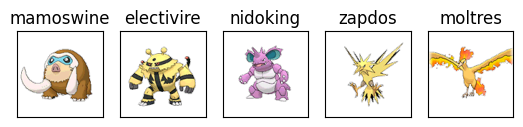

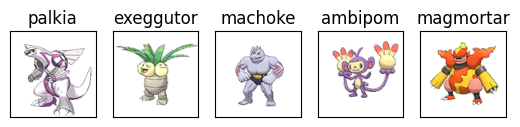

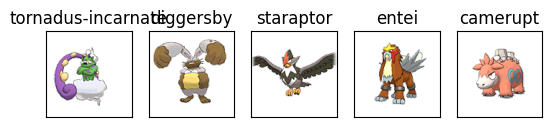

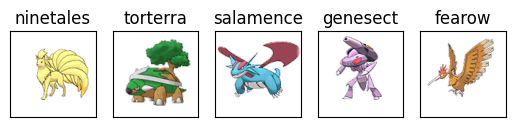

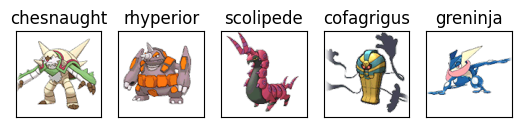

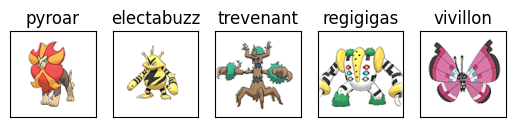

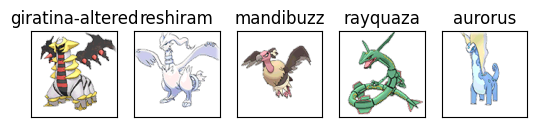

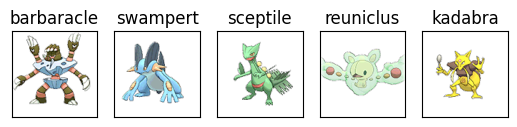

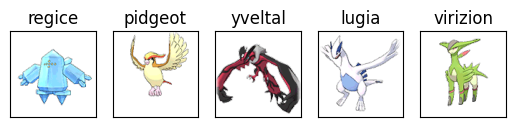

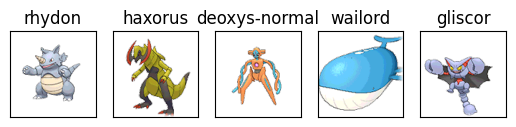

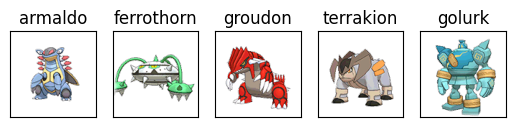

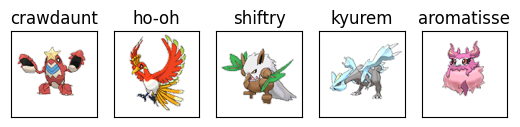

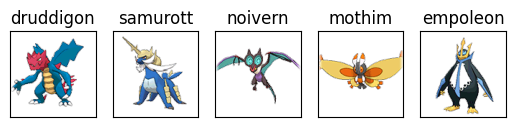

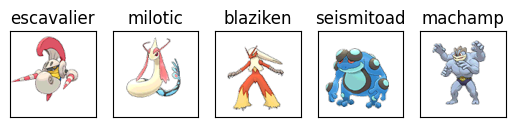

In [14]:
# TO DO: iterate over the dataloader and display all images with the name of the pokemon as title
for batch_data, batch_name in image_dataloader:
    print(batch_data.shape)
    plt.figure()

    for ib in range(batch_size):
        plt.subplot(1, batch_size, ib + 1)
        plt.imshow(batch_data[ib, :])
        plt.title(batch_name[ib])
        plt.xticks([]), plt.yticks([])
plt.show()

## Speech data

Let's now work with speech data. The audio signals are provided in the `data/audio_corpus/` folder.

### Example


In [15]:
# Load an audio file using the sf.read() function
x, sampling_frequency = sf.read("../data/audio_corpus/arctic_a0001.wav")

# Print the shape of the audio signal and the sampling frequency
print(x.shape)
print("Sampling frequency:", sampling_frequency, "Hz")

# The duration of the signal (in seconds) can be computed as follows:
duration = len(x) / sampling_frequency
print("Duration:", duration, "s")

# We can use the 'display(Audio())' function to have a graphical audio reader
display(Audio(data=x, rate=sampling_frequency))

(53680,)
Sampling frequency: 16000 Hz
Duration: 3.355 s


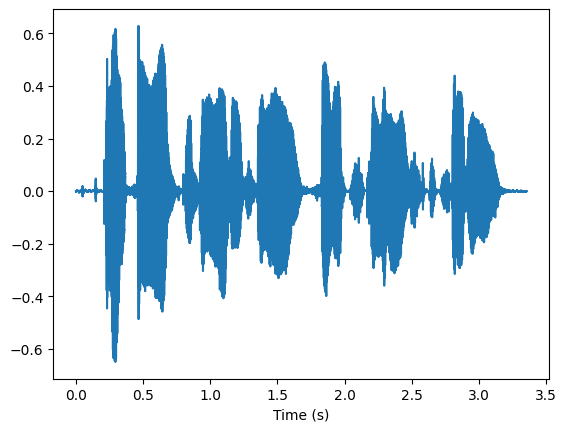

In [16]:
# We can plot the audio waveform as a function of time (in seconds)
t = torch.arange(len(x)) / sampling_frequency
plt.figure()
plt.plot(t, x)
plt.xlabel("Time (s)")
plt.show()

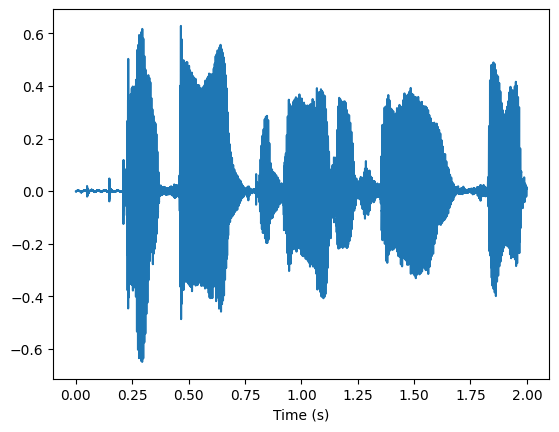

Duration: 2.0 s


In [17]:
max_dur = 2.0  # maximum duration in seconds
max_len = int(
    max_dur * sampling_frequency
)  # equivalent maximum length in number of samples

t = torch.arange(max_len) / sampling_frequency

# TO DO: Set the signal at a specified duration 'max_len'
# - first, initialize a tensor y from the numpy array x
y = torch.from_numpy(x)

# - then, use an 'if' condition:
#     - if the signal length is larger than max_len, then crop it
if len(y) > max_len:
    y = y[:max_len]

#     - if the signal length is smaller than max_len, then add zeros (use cat) accordingly at the end of the signal
else:
    y = torch.cat((y, torch.zeros(max_len - len(y))))

# Plot y
plt.figure()
plt.plot(t, y)
plt.xlabel("Time (s)")
plt.show()

duration = len(y) / sampling_frequency
print("Duration:", duration, "s")

### Dataset and dataloader

Now, we can create the speech Dataset.


In [40]:
class SpeechDataset(Dataset):
    def __init__(self, audio_dir, max_dur):
        """Initialize the attributes of the object of the class."""
        self.audio_dir = audio_dir
        self.max_dur = max_dur
        self.audio_path_list = sorted(self._find_files(audio_dir))

    def __len__(self):
        """Return the size of the dataset."""
        return len(self.audio_path_list)

    def __getitem__(self, index):
        """Return a data sample (= speech signal) for a given index."""

        # TO DO:
        # - get the audio path corresponding to 'index' (use the list 'self.audio_path_list')
        audio_path = self.audio_path_list[index]

        # - load the speech signal into a numpy array x
        x, sampling_frequency = sf.read(audio_path)

        # - transform x into a pytorch tensor y (you can use torch.from_numpy())
        y = torch.from_numpy(x)

        # - use a method (which you have to code) to set the length of x at a given duration 'self.max_dur'
        y = self._set_duration(y, self.max_dur, sampling_frequency)

        # - return the tensor y (which has duration max_dur)
        # - also get and return the name of the audio (as for images, use '.replace()')
        name = audio_path.replace(self.audio_dir, "").replace(".wav", "")

        return y, sampling_frequency, name

    def _find_files(self, directory, pattern="*.wav"):
        """Recursively find all files matching the pattern."""
        audio_path_list = []
        for root, dirnames, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                audio_path_list.append(os.path.join(root, filename))
        return audio_path_list

    def _set_duration(self, y, max_dur, sampling_frequency=16000):
        """Set the input signal at a specified duration."""
        # TO DO: code it
        max_len = int(
            max_dur * sampling_frequency
        )  # equivalent maximum length in number of samples

        if len(y) > max_len:
            y = y[:max_len]

        else:
            y = torch.cat((y, torch.zeros(max_len - len(y))))

        return y

In [41]:
# TO DO: Instanciate the dataset (specify the audio directory and a maximum duration of 2 seconds),
# Print the dataset's length, and the list of files
audio_dir = "../data/audio_corpus/"
max_dur = 2.0
dataset = SpeechDataset(audio_dir, max_dur)

print("Dataset length:", len(dataset))

audio_path_list = dataset.audio_path_list
for l in audio_path_list:
    print(l)

Dataset length: 15
../data/audio_corpus/arctic_a0001.wav
../data/audio_corpus/arctic_a0002.wav
../data/audio_corpus/arctic_a0003.wav
../data/audio_corpus/arctic_a0004.wav
../data/audio_corpus/arctic_a0005.wav
../data/audio_corpus/arctic_a0006.wav
../data/audio_corpus/arctic_a0007.wav
../data/audio_corpus/arctic_a0008.wav
../data/audio_corpus/arctic_a0009.wav
../data/audio_corpus/arctic_a0010.wav
../data/audio_corpus/arctic_a0011.wav
../data/audio_corpus/arctic_a0012.wav
../data/audio_corpus/arctic_a0013.wav
../data/audio_corpus/arctic_a0014.wav
../data/audio_corpus/arctic_a0015.wav


Speech signal shape: torch.Size([32000])


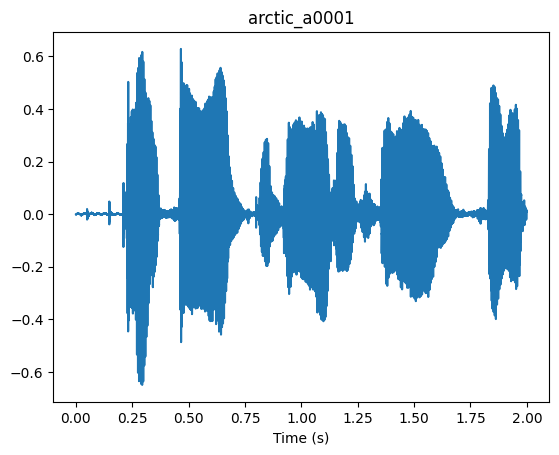

In [42]:
# TO DO: load the speech signal with index '0' from the dataset (and its name), print its shape,
# plot the signal (with the name as title) and the graphical audio reader


speech_example, speech_example_sampling_frequency, speech_example_name = dataset[0]

print("Speech signal shape:", speech_example.shape)

t = torch.arange(len(speech_example)) / speech_example_sampling_frequency

plt.figure()
plt.plot(t, speech_example)
plt.title(speech_example_name)
plt.xlabel("Time (s)")
plt.show()

display(Audio(data=speech_example, rate=speech_example_sampling_frequency))

In [ ]:
# TO DO: create a dataloader (batch size of 3), iterate over the dataloader and plot all the signals with name as title
batch_size = 3
speech_dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

for (
    batch_data,
    batch_sampling_frequencies,
    batch_names,
) in speech_dataloader:
    print(batch_data.shape)

    for b in range(batch_size):
        plt.subplot(1, batch_size, ib + 1)
        plt.imshow(batch_data[ib, :])
        plt.title(batch_name[ib])
        plt.xticks([]), plt.yticks([])
    t = torch.arange(len(speech_example)) / speech_example_sampling_frequency

    plt.figure()
    plt.plot(t, speech_example)
    plt.title(speech_example_name)
    plt.xlabel("Time (s)")
    plt.show()

    display(Audio(data=speech_example, rate=speech_example_sampling_frequency))

torch.Size([3, 32000])


## Text dataset

Finally, let's work a bit with text data. Each text file in the corpus consists of a written feedback about a movie, along with a label (1 = positive, 0 = negative).

Note that this part is concise because preprocessing textual data is quite involved. It will be studied in more details in the second part of the course (NLP students only).

Therefore, the TextDataset class is provided below. Note that in addition to the classical methods (`_init_`, `__getitem__`, `_len__`, and `_find_files`), there are some more methods to preprocess it. In particular:

- `_create_vocabulary` gets the list of all words in the corpus to create a vocabulary.
- `_tokenize_text` transforms each word into an integer (called _token_).

This allows to process textual data as numbers, which is more convenient for neural nets. Checking these methods in details is left as optional work for NLP students.


In [22]:
class TextDataset(Dataset):
    def __init__(self, text_dir, max_seq_length=128):
        """Initialize the attributes of the object of the class."""
        self.text_dir = text_dir
        self.max_seq_len = max_seq_length
        self.text_files = sorted(self._find_files(text_dir))
        self.labels = self._get_labels()
        self.vocab = sorted(self._create_vocabulary())
        self.word_to_index = {word: idx for idx, word in enumerate(sorted(self.vocab))}
        self.word_to_index["[PAD]"] = -1

    def __len__(self):
        """Return the size of the dataset."""
        return len(self.text_files)

    def __getitem__(self, index):
        """Return a data sample (= text tokens and label) for a given index."""
        # get the index-th text file from the list of text files defined in __init__
        text_file = self.text_files[index]
        # return a list of all tokens in the text
        tokens = self._tokenize_text(text_file)
        # use the word_to_index mapping to transform the tokens into indices and save them into an IntTensor
        x = torch.IntTensor([self.word_to_index[word] for word in tokens])
        # get the index-th label and store it into a FloatTensor
        y = torch.FloatTensor([self.labels[index]])
        # stores the text indices and the label into a dictionary
        features = {"token_ids": x, "labels": y}
        return features

    def _find_files(self, directory, pattern="*.txt"):
        """Recursively find all files matching the pattern."""
        files = []
        for root, dirnames, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                files.append(os.path.join(root, filename))
        return files

    def _get_labels(self):
        """Extract the labels from the given text files."""
        labels = []
        for filepath in self.text_files:
            text, label = list(open(filepath, "r"))[0].split("\t")
            labels.append(int(label))
        return labels

    def _create_vocabulary(self):
        """Create a vocabulary of unique words from the given text files."""
        all_texts = [
            list(open(filepath, "r"))[0].strip().lower() for filepath in self.text_files
        ]
        letters = string.ascii_lowercase
        word_string = " ".join(all_texts)
        not_letters = set(
            [char for char in word_string if char not in letters and char != " "]
        )
        for char in not_letters:
            word_string = word_string.replace(char, " ")
        vocab = set(word_string.split())
        return list(vocab)

    def _tokenize_text(self, text_file):
        """
        Remove non-characters from the text and pads the text to max_seq_len.
        *!* Padding is necessary for ensuring that all text_files have the same size
        *!* This is required since DataLoader cannot handle tensors of variable length

        Return a list of all tokens in the text
        """
        text = list(open(text_file, "r"))[0].strip().lower()
        letters = string.ascii_lowercase
        not_letters = set(
            [char_ for char_ in text if char_ not in letters and char_ != " "]
        )
        for char in not_letters:
            text = text.replace(char, " ")
        tokens = text.split()
        for i in range(self.max_seq_len - len(tokens)):
            tokens.append("[PAD]")
        return tokens

In [23]:
# TO DO: create a text dataset (define the text_dir) and display its size.
# Load the sample of index 0 and print the corresponding token and label.


In [24]:
# TO DO: create a dataloader for the text data (batch_size=2) and print the contents of each batch (tokens and labels)
